# 0. Import Libaries + Data

In [1]:
# !pip install optuna
# !pip install vnstock

!pip install hypopt
!pip install keras_tuner

In [2]:
import pandas as pd
import numpy as np
from TA import *

import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
import matplotlib.dates as mdates
%matplotlib inline

from datetime import datetime
import dateutil.parser
import copy

from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics import classification_report,roc_auc_score, make_scorer
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin


import tensorflow as tf
from tensorflow.keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.regularizers import l1, l2
from keras.optimizers import Adam

from sklearn import tree
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler

from hypopt import GridSearch
import keras_tuner as kt

from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.losses import BinaryCrossentropy

from optuna import Trial, create_study, create_trial

from vnstock import Vnstock
import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

Phiên bản Vnstock 3.2.5 đã có mặt, vui lòng cập nhật với câu lệnh : `pip install vnstock --upgrade`.
Lịch sử phiên bản: https://vnstocks.com/docs/tai-lieu/lich-su-phien-ban
Phiên bản hiện tại 3.2.3

Phiên bản Vnai 2.0.4 đã có mặt, vui lòng cập nhật với câu lệnh : `pip install vnai --upgrade`.
Lịch sử phiên bản: https://pypi.org/project/vnai/#history
Phiên bản hiện tại 2.0.2

In [3]:
def VN_Stock_close_data(start_time,end_time, list_choice = 'VN30', interval = '1D'):
    stock = Vnstock().stock(symbol='ACB', source='VCI')
    stock_list = stock.listing.symbols_by_group(list_choice)

    futures = pd.DataFrame()

    for ma_ck in stock_list:
        try:
            stock = Vnstock().stock(symbol= ma_ck, source='VCI')
            df = stock.quote.history(start= start_time, end= end_time, interval= interval)
            df = df.set_index('time')
            df = pd.DataFrame(df['close'])
            df.columns = [ma_ck]
            df.index = df.index.date
            futures = pd.concat([futures,df],axis = 1, join = 'outer').sort_index()
        except:
            continue

    if interval != '1D':
      futures['Date']= pd.to_datetime(futures.index, format='%Y-%m-%d')
    else:
      futures['Date'] = pd.to_datetime(futures.index, format='%Y-%m-%d %H:%M:%S')
    futures.set_index('Date', inplace=True)

    return futures

In [4]:
def VN_Stock_fully_data(start_time,end_time, list_choice = 'VN30', interval = '1D'):
    stock = Vnstock().stock(symbol='ACB', source='VCI')
    stock_list = stock.listing.symbols_by_group(list_choice)
    data = []

    for ma_ck in stock_list:
        print(ma_ck)
        try:
            stock = Vnstock().stock(symbol= ma_ck, source='VCI')
            df = stock.quote.history(start= start_time, end= end_time, interval= interval)
            df = df.set_index('time')
            df.name = ma_ck
            if interval != '1D':
              df['Date']= pd.to_datetime(df.index,format='%Y-%m-%d')
            else:
              df['Date'] = pd.to_datetime(df.index,format='%Y-%m-%d %H:%M:%S')
            df.set_index('Date', inplace=True)
            data.append(df)
        except:
            continue


    return data

In [5]:
# def EU_Stock_data(start_time,end_time, time_range = 'max'):
#     """Lấy dữ liệu giá Close của 50 công ty trên sàn Euro_STOXX 50 vào thời gian cho trước"""

#     stock_list = ['AAPL', 'NVDA', 'MSFT', 'AMZN', 'GOOGL', 'META', 'TSLA', 'AVGO', 'TSM', 'BRK.A', 'LLY', 'WMT', 'JPM', 'V', 'MA', 'XOM', 'UNH', 'ORCL', 'COST', 'PG', 'HD', 'ACN', 'WFC', 'CSCO', 'NOW', 'AXP', 'BX', 'MCD', 'IBM', 'AZN', 'PEP', 'TMO', 'AMD', 'MS', 'DIS', 'ABT', 'PFE', 'CVX', 'CRM', 'INTC', 'CMCSA', 'LIN', 'NKE', 'T', 'MDT', 'UNP', 'HON', 'PM', 'KO', 'MRK']

#     futures = pd.DataFrame()

#     # xét từng mã
#     for symbol in stock_list:
#         try:
#             df = yf.Ticker(symbol).history(period = time_range, start = start_time, end = end_time)
#             df = pd.DataFrame(df['Close'])
#             df.columns = [symbol]
#             df.index = df.index.date
#             futures = pd.concat([futures,df],axis = 1, join = 'outer').sort_index()
#         except:
#             continue

#     futures['Date'] = pd.to_datetime(futures.index, format='%Y-%m-%d')
#     futures.set_index('Date', inplace=True)

#     return futures

In [6]:
start_time = '2017-12-31'
# start_time = '2023-12-31'
end_time = '2025-03-01'

list_choice = 'VN30'

daily_full = VN_Stock_fully_data(start_time, end_time)

ACB
BCM
BID
BVH
CTG
FPT
GAS
GVR
HDB
HPG
LPB
MBB
MSN
MWG
PLX
SAB
SHB
SSB
SSI
STB
TCB
TPB
VCB
VHM
VIB
VIC
VJC
VNM
VPB
VRE


In [7]:
# start_time = '2017-12-31'
# end_time = '2025-03-01'

# list_choice = 'VN30'

# hourly_test = VN_Stock_close_data(start_time, end_time, interval = '1H')
# hourly_test

In [8]:
# start_time = '2017-12-31'
# end_time = '2025-03-01'

# list_choice = 'VN30'

# daily_test = VN_Stock_close_data(start_time, end_time)
# daily_test

In [9]:
# plt.plot(30 - daily_test.isna().sum(axis = 1))
# plt.title(f"Số lượng công ty trên {list_choice} có dữ liệu theo thời gian")
# plt.xlabel("Thời gian")
# plt.ylabel("Số lượng công ty")

# 1. Analysis

In [10]:
def describe_data_list(data):
  ''' Hàm mô tả dữ liệu
      INPUT: data_list(list): Một list bao gồm các dataframe
        * Lưu ý: Nếu chỉ sử dụng 1 công ty, chỉ cần truyền vào 1 dataframe dưới dạng list: (VD: [df])
      OUTPUT: các thông tin chung và mô tả các biến số của tất cả dataframe có trong list
  '''
  print(data.name)
  print(data.info())
  print(data.describe())
  print("=========================================")

  return

In [11]:
# plt.figure(figsize = (24, 12))
# plt.tight_layout()
# plt.xticks([])
# plt.yticks([])
# sns.reset_orig()
# plt.suptitle("Khối lượng giao dịch của các công ty trong VN30")
# for x in range(1,31):
#   ax = plt.subplot(5,6, x)
#   ax.plot(daily_full[x-1].index,daily_full[x-1]['volume'])
#   plt.xticks([])
#   plt.title(daily_full[x-1].name)
#   # plt.savefig(daily_full[x].name)

# 2. Cleaning Data

# 3. Feature Engineering

In [12]:
# def MA(data, period):
#    return data.rolling(period).mean()

# def EMA(data, period):
#     return pd.Series(data.ewm(ignore_na=False, span=period, adjust=True).mean())

# def MACD(data,period_fast = 1,period_slow = 5):
#     '''Hàm dùng để tính MACD
#        INPUT:
#           data(series): Dãy dữ liệu giá của chứng khoán trong 1 khoảng thời gian
#           period_fast, period_slow: Chu trình fast,slow; mặc định là (1,5) do số lượng dữ liệu giới hạn
#        OUTPUT: MACD(series): Dãy kết quả MACD
#     '''
#     EMA_fast = EMA(data,period_fast)
#     EMA_Slow = EMA(data,period_slow)
#     return EMA_fast - EMA_Slow

# def RSI(data, period  = 6):
#     '''Hàm dùng để tính RSI (đã scaled)
#        INPUT:
#           data(series): Dãy dữ liệu giá của chứng khoán trong 1 khoảng thời gian
#           period: Chu trình RSI; mặc định là 5  do số lượng dữ liệu giới hạn
#        OUTPUT: RSI(Series): Dãy kết quả RSI
#     '''
#     # Tính sự thay đổi hằng ngày
#     delta = data.diff()

#     gain = (delta.where(delta > 0, 0))
#     loss = (-delta.where(delta < 0, 0))

#     # Tính trung bình tăng/ trung bình giảm trong chu kì
#     avg_gain = gain.rolling(window=period).mean()
#     avg_loss = loss.rolling(window=period).mean()

#     # Tính rsi
#     rs = avg_gain / avg_loss
#     rsi = (100 - (100 / (1 + rs))) / 100

#     return rsi

# def Psy_line(data, period = 110):
#     better_candle = data.rolling(2).apply(lambda x: ((x.iloc[1] - x.iloc[0])>0).astype(int))
#     return better_candle.rolling(period).sum()/period

# def ROC(data, period):
#     # return data.diff(period)
#     return data.pct_change(period)

In [13]:
def feature_engineering(data, period = 20, momentum_threshold = 0):
  '''Hàm dùng để tạo feature từ dữ liệu đã được chuyển về daily
      INPUT: data_list(list): Một list bao gồm các dataframe đã được chuyển về daily
        * Lưu ý: Nếu chỉ sử dụng 1 công ty, chỉ cần truyền vào 1 dataframe dưới dạng list: (VD: [df])
      OUTPUT: feature_data(list): Danh sách các dataframe sau khi tạo feature
  '''

  # Tạo 1 bản copy của data
  temp = copy.deepcopy(data)
  temp = temp[temp['close'] != 0]
  temp['Symbol'] = data.name
  # # Tính MA
  for x in [20,60,252]:
    # feature = 'MA' + str(x)
  #   # temp[feature] = MA(temp['close'], x)
  #   feature = 'EMA' + str(x)
  #   temp[feature] = EMA(temp['close'], x)
  #   # feature = 'MA_volume' + str(x)
  #   # temp[feature] = MA(temp['volume'], x)
  #   # feature = 'EMA_volume' + str(x)
  #   # temp[feature] = EMA(temp['volume'], x)
    feature = 'RSI' + str(x)
    temp[feature] = RSI(temp['close'],x)
    feature = 'PSY' + str(x)
    temp[feature] = Psy_line(temp['close'],x)

  for x in [1,3,5,10,15,20,40,60]:
    # feature = 'P' + str(x)
    # temp[feature] = temp['close'].shift(x)
    feature = 'ROC' + str(x)
    temp[feature] = ROC(temp['close'],x)

  temp['MACD_1_5'] = MACD(temp['close'],1,5)
  temp['MACD_5_20'] = MACD(temp['close'],5,20)
  temp['MACD_20_60'] = MACD(temp['close'],20,60)

  temp['Volume'] = temp['volume']

  temp['signal_momentum'] = temp['close'].rolling(period).apply(lambda x: x.iloc[period - 1] / x.iloc[0] - 1)
  # temp['signal_momentum'] = [1 if x > momentum_threshold else -1 if x < -momentum_threshold else 0 for x in temp['momentum']]
  # temp['signal_momentum'] = [1 if x > momentum_threshold else 0 for x in temp['momentum']]


  temp['Future_result'] = temp['close'].rolling(2).apply(lambda x: x.iloc[1] - x.iloc[0]).shift(-1)

  temp['good_signal']= ((temp["Future_result"] * (temp["signal_momentum"]>0)) > 0).astype(int)

  # temp['good_signal']= ((temp["Future_result"] * np.sign(temp['signal_momentum'])) > 0).astype(int)


  temp.drop(columns = ['open','high','low','volume','close','Future_result'], inplace = True)

  # Xóa những cột xuất hiện NA (Xảy ra với các hàng đầu của dữ liệu khi không có hơn 5 ngày để quan sát RSI)
  temp.dropna(axis=0, how="any", inplace = True)


  # Đặt tên data để dễ phân biệt
  temp.name = data.name + "_feature"


  return temp


In [14]:
feature = pd.DataFrame(np.empty((0, 21)))
for x in range(0,30):
  temp = feature_engineering(daily_full[x])
  feature.columns = temp.columns
  feature = pd.concat([feature,temp], axis = 0)
  # print(feature.shape)
feature = feature.sort_index()


In [15]:
feature = pd.get_dummies(feature, columns=['Symbol'], drop_first = True)
feature

,RSI20,PSY20,RSI60,PSY60,RSI252,PSY252,ROC1,ROC3,ROC5,ROC10,...,Symbol_TCB,Symbol_TPB,Symbol_VCB,Symbol_VHM,Symbol_VIB,Symbol_VIC,Symbol_VJC,Symbol_VNM,Symbol_VPB,Symbol_VRE
2019-01-04,0.260000,0.25,0.403292,0.333333,0.492356,0.456349,0.006693,-0.043257,-0.014417,-0.043257,...,False,False,False,False,False,False,False,False,False,False
2019-01-04,0.123959,0.30,0.319276,0.383333,0.495924,0.456349,-0.010331,-0.041695,-0.057384,-0.079977,...,False,False,False,False,False,False,True,False,False,False
2019-01-04,0.225907,0.30,0.414148,0.433333,0.468317,0.432540,-0.007432,-0.014391,-0.058181,-0.115856,...,False,False,False,False,False,False,False,False,False,True
2019-01-04,0.389565,0.30,0.454268,0.383333,0.510975,0.484127,-0.014156,-0.082719,-0.032240,-0.052259,...,False,False,False,False,False,False,False,False,False,False
2019-01-04,0.235294,0.10,0.365217,0.216667,0.478238,0.365079,0.000000,-0.025180,-0.025180,-0.052448,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-28,0.688312,0.45,0.637387,0.466667,0.561680,0.440476,-0.020761,-0.010490,-0.024138,0.040441,...,False,False,False,False,False,False,False,False,False,False
2025-02-28,0.595960,0.50,0.574335,0.516667,0.483083,0.428571,0.000000,-0.007273,0.001222,0.007380,...,False,False,False,False,False,False,False,False,False,False
2025-02-28,0.579592,0.50,0.516949,0.416667,0.512124,0.436508,0.000000,-0.002654,-0.007396,0.015676,...,False,False,False,False,False,False,False,False,True,False
2025-02-28,0.523585,0.55,0.613520,0.516667,0.530721,0.396825,0.005035,0.000000,0.007064,0.014743,...,False,False,False,False,True,False,False,False,False,False


In [16]:
# feature.to_csv("feature.csv")

In [17]:
# corr = feature.drop(columns = ['Symbol']).corr()
# corr.style.background_gradient(cmap='coolwarm')

In [18]:
feature

,RSI20,PSY20,RSI60,PSY60,RSI252,PSY252,ROC1,ROC3,ROC5,ROC10,...,Symbol_TCB,Symbol_TPB,Symbol_VCB,Symbol_VHM,Symbol_VIB,Symbol_VIC,Symbol_VJC,Symbol_VNM,Symbol_VPB,Symbol_VRE
2019-01-04,0.260000,0.25,0.403292,0.333333,0.492356,0.456349,0.006693,-0.043257,-0.014417,-0.043257,...,False,False,False,False,False,False,False,False,False,False
2019-01-04,0.123959,0.30,0.319276,0.383333,0.495924,0.456349,-0.010331,-0.041695,-0.057384,-0.079977,...,False,False,False,False,False,False,True,False,False,False
2019-01-04,0.225907,0.30,0.414148,0.433333,0.468317,0.432540,-0.007432,-0.014391,-0.058181,-0.115856,...,False,False,False,False,False,False,False,False,False,True
2019-01-04,0.389565,0.30,0.454268,0.383333,0.510975,0.484127,-0.014156,-0.082719,-0.032240,-0.052259,...,False,False,False,False,False,False,False,False,False,False
2019-01-04,0.235294,0.10,0.365217,0.216667,0.478238,0.365079,0.000000,-0.025180,-0.025180,-0.052448,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-28,0.688312,0.45,0.637387,0.466667,0.561680,0.440476,-0.020761,-0.010490,-0.024138,0.040441,...,False,False,False,False,False,False,False,False,False,False
2025-02-28,0.595960,0.50,0.574335,0.516667,0.483083,0.428571,0.000000,-0.007273,0.001222,0.007380,...,False,False,False,False,False,False,False,False,False,False
2025-02-28,0.579592,0.50,0.516949,0.416667,0.512124,0.436508,0.000000,-0.002654,-0.007396,0.015676,...,False,False,False,False,False,False,False,False,True,False
2025-02-28,0.523585,0.55,0.613520,0.516667,0.530721,0.396825,0.005035,0.000000,0.007064,0.014743,...,False,False,False,False,True,False,False,False,False,False


In [19]:
def Volatility_scale(train_data, ignore_na=False, adjust = True, com = 60, min_periods=0):

    scaled_data = pd.DataFrame(columns=train_data.columns, dtype=float)
    scaled_data.drop(columns = ['Symbol'], inplace = True)

    for company, group in train_data.groupby('Symbol'):  # Process each company separately
      non_scaled_data = group[['signal_momentum',]]

      # volume_data = group[['MA_volume20','MA_volume60','MA_volume252']]
      volume_data = group[['Volume']]

      temp = group
      temp.drop(columns = ['signal_momentum','Symbol','Volume'], inplace = True)
      # Tính daily volatility (vol)
      temp = temp.ewm(ignore_na=ignore_na,
                            adjust=adjust,
                            com=com,
                            min_periods=min_periods).std(bias = False)

      temp  /= np.sqrt(252)  # scale lại theo 252 ngày active trading

      volume_data = (volume_data - volume_data.rolling(window=60,min_periods = 1).mean()) / volume_data.rolling(window=60, min_periods = 1).std()

      temp = pd.concat([temp, non_scaled_data], axis=1)
      temp = pd.concat([temp, volume_data], axis=1)

      scaled_data = pd.concat([scaled_data,temp], axis = 0)

    return scaled_data

scaler = FunctionTransformer(Volatility_scale)

In [20]:
# def Volatility_scale(train_data, ignore_na=False, adjust = True, com = 60, min_periods=0):

#     scaled_data = pd.DataFrame(columns=train_data.columns, dtype=float)
#     scaled_data.drop(columns = ['Symbol'], inplace = True)

#     for company, group in train_data.groupby('Symbol'):  # Process each company separately
#     #   non_scaled_data = group[['signal_momentum','RSI20','RSI60','RSI252','PSY20','PSY60','PSY252']]

#     #   # volume_data = group[['MA_volume20','MA_volume60','MA_volume252']]
#     #   volume_data = group[['Volume']]

#       temp = group
#       temp.drop(columns = ['Symbol'], inplace = True)
#     #   # Tính daily volatility (vol)
#     #   temp = temp.ewm(ignore_na=ignore_na,
#     #                         adjust=adjust,
#     #                         com=com,
#     #                         min_periods=min_periods).std(bias = False)

#     #   temp  /= np.sqrt(252)  # scale lại theo 252 ngày active trading

#     #   volume_data = (volume_data - volume_data.rolling(window=60,min_periods = 1).mean()) / volume_data.rolling(window=60, min_periods = 1).std()

#     #   temp = pd.concat([temp, non_scaled_data], axis=1)
#     #   temp = pd.concat([temp, volume_data], axis=1)

#       scaled_data = pd.concat([scaled_data,temp], axis = 0)

#     return scaled_data

# scaler = FunctionTransformer(Volatility_scale)

In [21]:
# corr = Volatility_scale(feature).corr()
# corr.style.background_gradient(cmap='coolwarm')

In [22]:
# class TimeSeriesScalerDF(BaseEstimator, TransformerMixin):
#     def __init__(self):
#         self.previous_max = {}  # Store max per column

#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         X = X.copy()
#         transformed_df = pd.DataFrame(index=X.index, columns=X.columns)

#         for col in X.columns:
#             col_values = X[col].values.astype(float)
#             running_max = self.previous_max.get(col, col_values[0])  # Keep previous max

#             transformed_col = np.zeros_like(col_values)
#             for i in range(len(col_values)):
#                 if i == 0 and col not in self.previous_max:
#                     transformed_col[i] = col_values[i]  # Keep first value
#                 else:
#                     running_max = max(running_max, col_values[i - 1])
#                     transformed_col[i] = (col_values[i] - running_max) / running_max if running_max != 0 else 0

#             transformed_df[col] = transformed_col
#             self.previous_max[col] = running_max  # Save max for next batch

#         return transformed_df


In [23]:
# for x ,y in trainX.groupby('Symbol'):
#     print(f"Processing {x}")
#     print(y)

In [24]:
class TimeSeriesScalerDF(BaseEstimator, TransformerMixin):
    def __init__(self, list_choice):
        stock = Vnstock().stock(symbol='ACB', source='VCI')
        self.company_column = stock.listing.symbols_by_group(list_choice) # Column name identifying companies
        self.previous_min = {}  # Store cumulative min per (company, column)
        self.previous_max = {}  # Store cumulative max per (company, column)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        transformed_df = pd.DataFrame(columns=X.columns, dtype=float)
        transformed_df.drop(columns = ['Symbol'], inplace = True)
        print(X.groupby(self.company_column))
        for company, group in X.groupby('Symbol'):  # Process each company separately
            temp = pd.DataFrame(index= group.index, columns=X.columns, dtype=float)
            temp.drop(columns = ['Symbol'], inplace = True)
            # print(f"Processing {company}")
            # print(group)
            for col in group.columns:
                if col == 'Symbol':
                    continue  # Skip the company column

                col_values = group[col].astype(float)
                # print(col_values)

                # Retrieve previous min/max for this (company, column) pair
                key = (company, col)
                running_min = self.previous_min.get(key, col_values.iloc[0])
                running_max = self.previous_max.get(key, col_values.iloc[0])

                # Compute cumulative min and max
                cumin_t = np.minimum.accumulate(np.insert(col_values.values, 0, running_min))[1:]
                cumax_t = np.maximum.accumulate(np.insert(col_values.values, 0, running_max))[1:]

                # print([cumin_t,cumax_t])

                # Apply scaling formula
                transformed_col = (col_values - cumin_t) / (cumax_t - cumin_t)
                transformed_col = np.nan_to_num(transformed_col, nan=0.0)  # Handle division by zero

                temp[col] = transformed_col

                # Store the last min and max for future use
                self.previous_min[key] = cumin_t[-1]
                self.previous_max[key] = cumax_t[-1]

            transformed_df = pd.concat([transformed_df,temp], axis = 0)
            transformed_df = transformed_df.sort_index()

        return transformed_df


In [25]:
def prepare_X_y(df):
    ''' Hàm chia X,y từ dữ liệu
          INPUT: df(dataframe): dữ liệu đã được tạo feature
          OUTPUT: X,y(dataframe): X là các biến độc lập, y là biến phụ thuộc sử dụng trong các mô hình
    '''
    columns = df.columns.tolist()
    columns.remove('good_signal')
    X = df[columns]
    y = df['good_signal']

    return X, y

def split_train_test(X, y, train_size=0.8):
    ''' Hàm chia tập train, test cho dữ liệu:
          INPUT:
            X,y(dataframe): X là các biến độc lập, y là biến phụ thuộc sử dụng trong các mô hình
            train_size: tỉ lệ chia train/test; mặc định là 0.8
          OUTPUT: trainX, testX ,trainY, testY(dataframe): các tập train/test đã được chia ra
    '''
    # Chia tập train/test
    # trainX, testX ,trainY, testY = train_test_split(X, y, train_size=train_size, shuffle=False)

    split_idx = int(len(X) * train_size)  # Compute the split index

    trainX, testX = X.loc[X.index <= dateutil.parser.parse(str(X.iloc[[split_idx]].index[0]))], X.loc[X.index > dateutil.parser.parse(str(X.iloc[[split_idx]].index[0]))]  # Non-overlapping split
    trainY, testY = y.loc[y.index <= dateutil.parser.parse(str(y.iloc[[split_idx]].index[0]))], y.loc[y.index > dateutil.parser.parse(str(y.iloc[[split_idx]].index[0]))]

    # In ra những thông tin chi tiết về kích cỡ tập train/test; và khoảng thời gian xử lí
    print('TrainX:' + str(trainX.shape) + f". Dữ liệu từ ngày {trainX.index.min().date()} đến {trainX.index.max().date()}")
    print('TrainY:' + str(trainY.shape) + f". Dữ liệu từ ngày {trainY.index.min().date()} đến {trainY.index.max().date()}")
    print('TestX:' + str(testX.shape) + f". Dữ liệu từ ngày {testX.index.min().date()} đến {testX.index.max().date()}")
    print('TestY:' + str(testY.shape) + f". Dữ liệu từ ngày {testY.index.min().date()} đến {testY.index.max().date()}")

    return trainX, testX ,trainY, testY

In [26]:
# def manual_time_series_split(data, n_splits = 5):
#     """Manually splits time series data into train-test sets."""
#     n_samples = len(data)
#     split_size = (n_samples - n_splits) // (n_splits + 1)  # Size of each test set

#     splits = []
#     for i in range(n_splits):
#         train_end = split_size * (i + 1) + i  # Expanding train set
#         test_start = train_end
#         test_end = test_start + split_size

#         train_indices = np.argwhere(data.index <= dateutil.parser.parse(str(data.iloc[[train_end]].index[0]))).flatten().tolist()
#         test_indices = np.argwhere((data.index <= dateutil.parser.parse(str(data.iloc[[test_end]].index[0]))) & (data.index > dateutil.parser.parse(str(data.iloc[[test_start]].index[0])))).flatten().tolist()

#         splits.append((train_indices, test_indices))

#     return splits

In [27]:
# # Scale data before applying PCA
# # Scaled_data = Volatility_scale(trainX)[1:]
# Scaled_data = Volatility_scale(trainX)

# # Use fit and transform method

# # Set the n_components=3
# principal=PCA(n_components=2)
# principal.fit(Scaled_data)
# x=principal.transform(Scaled_data)

# # Check the dimensions of data after PCA
# print(x.shape)

# plt.figure(figsize=(10,10))
# plt.scatter(x[:,0],x[:,1],c=trainY,cmap='plasma')
# plt.xlabel('pc1')
# plt.ylabel('pc2')
# plt.show()



In [28]:
X, y = prepare_X_y(feature)

trainX, testX ,trainY, testY = split_train_test(X, y)
print(trainX)
print(trainY)

TrainX:(35890, 48). Dữ liệu từ ngày 2019-01-04 đến 2023-12-13
TrainY:(35890,). Dữ liệu từ ngày 2019-01-04 đến 2023-12-13
TestX:(8970, 48). Dữ liệu từ ngày 2023-12-14 đến 2025-02-28
TestY:(8970,). Dữ liệu từ ngày 2023-12-14 đến 2025-02-28
               RSI20  PSY20     RSI60     PSY60    RSI252    PSY252      ROC1  \
2019-01-04  0.260000   0.25  0.403292  0.333333  0.492356  0.456349  0.006693   
2019-01-04  0.123959   0.30  0.319276  0.383333  0.495924  0.456349 -0.010331   
2019-01-04  0.225907   0.30  0.414148  0.433333  0.468317  0.432540 -0.007432   
2019-01-04  0.389565   0.30  0.454268  0.383333  0.510975  0.484127 -0.014156   
2019-01-04  0.235294   0.10  0.365217  0.216667  0.478238  0.365079  0.000000   
...              ...    ...       ...       ...       ...       ...       ...   
2023-12-13  0.456522   0.40  0.445388  0.416667  0.510857  0.492063 -0.009259   
2023-12-13  0.352941   0.45  0.493596  0.433333  0.530231  0.440476 -0.008995   
2023-12-13  0.414062   0.45  0.40

In [29]:
# # Scale data before applying PCA
# Scaled_data = TimeSeriesScalerDF().transform(trainX)
# # Scaled_data = trainX

# # Use fit and transform method

# # Set the n_components=2

# principal=PCA(n_components=2)
# principal.fit(Scaled_data)
# x=principal.transform(Scaled_data)

# plt.figure(figsize=(10,10))
# plt.scatter(x[:,0],x[:,1],c=trainY,cmap='plasma')
# plt.xlabel('pc1')
# plt.ylabel('pc2')
# plt.show()


In [30]:
# trainX = pd.DataFrame(np.empty((0,36)))
# testX = pd.DataFrame(np.empty((0,36)))
# trainY = pd.Series()
# testY = pd.Series()
# for x in range(0,30):
#   temp = feature_engineering(daily_full[x])

#   X, y = prepare_X_y(temp)

#   trainX_temp, testX_temp ,trainY_temp, testY_temp = split_train_test(X, y)
#   trainX.columns = trainX_temp.columns
#   trainX = pd.concat([trainX,trainX_temp], axis = 0)
#   testX.columns = testX_temp.columns
#   testX = pd.concat([testX,testX_temp], axis = 0)
#   trainY = pd.concat([trainY,trainY_temp], axis = 0)
#   testY = pd.concat([testY,testY_temp], axis = 0)

#   print([trainX.shape,trainY.shape,testX.shape, testY.shape])

# 4. Model

## Random forest

In [31]:
# # Generate a sample time series dataset
# X, y = make_regression(n_samples=100, n_features=5, noise=0.1, random_state=42)

# # Manually define test fold indices for a time series split (5 folds)
# n_samples = len(y)
# n_splits = 5
# test_size = n_samples // (n_splits + 1)  # Ensure growing training set
# test_fold = np.full(n_samples, -1)  # Initialize all as training (-1)

# for i in range(n_splits):
#     start_test = (i + 1) * test_size
#     end_test = start_test + test_size
#     test_fold[start_test:end_test] = i  # Assign fold number

# # Create PredefinedSplit
# ps = PredefinedSplit(test_fold)


# split_idx = int(len(X) * train_size)  # Compute the split index

# trainX, testX = X.loc[X.index <= dateutil.parser.parse(str(X.iloc[[split_idx]].index[0]))], X.loc[X.index > dateutil.parser.parse(str(X.iloc[[split_idx]].index[0]))]  # Non-overlapping split
# trainY, testY = y.loc[y.index <= dateutil.parser.parse(str(y.iloc[[split_idx]].index[0]))], y.loc[y.index > dateutil.parser.parse(str(y.iloc[[split_idx]].index[0]))]


In [32]:
def instantiate_random_trees(trial) -> RandomForestClassifier:
  params = {
    'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
    'max_depth': trial.suggest_int('max_depth', 10, 25),
    'min_samples_split': trial.suggest_float('min_samples_split', 0,1),
    'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0,1),
    'max_features': trial.suggest_float('max_features', 0,1),
    'n_jobs': -1,
    'random_state': 42
  }
  return RandomForestClassifier(**params)

def instantiate_model(trial : Trial) -> Pipeline:

  random_tree_model = instantiate_random_trees(trial)

  pipeline = Pipeline(
      [
          # ("scaler", scaler),
          ("classifier", random_tree_model),
      ]
  )

  return pipeline

def objective(trial : Trial, X : pd.DataFrame, y : np.ndarray | pd.Series, random_state : int=42) -> float:

  model = instantiate_model(trial)

  split = TimeSeriesSplit(n_splits= 5)
  roc_auc_scorer = make_scorer(roc_auc_score)
  scores = cross_val_score(model, X,y, scoring=roc_auc_scorer, cv= split)

  return np.min([np.mean(scores), np.median([scores])])

In [33]:
def train_random_forest_optuna(trainX,trainY):

  study = create_study(study_name='optimization', direction='maximize')

  study.optimize(lambda trial: objective(trial, trainX, trainY), n_trials=100)

  best_trial = study.best_trial

  model = instantiate_model(best_trial)
  model.fit(trainX, trainY)

  return model

In [34]:
def train_random_forest(trainX,trainY):
  ''' Hàm train mô hình Random Forest
      INPUT: trainX,trainY(dataframe): các tập train/test đã được chia ra dùng để huấn luyện
      OUTPUT: pipeline(pipeline): mô hình đã được train
  '''

  # Tạo pipeline bao gồm 2 bước: scale các feature và Random Forest
  pipeline = Pipeline(
      [
          # ("scaler", TimeSeriesScalerDF('VN30')),
          # ("scaler", scaler),
          ("classifier", RandomForestClassifier()),
          # ("classifier", DecisionTreeClassifier()),

      ]
  )

  # Fit mô hình
  pipeline.fit(trainX,trainY)

  return pipeline

In [35]:
test_model = train_random_forest(trainX,trainY)

# test_model = train_random_forest_optuna(trainX,trainY)

In [36]:
prediction = test_model.predict(trainX)
prediction *= (trainX["signal_momentum"]>0)
print(classification_report((trainX["signal_momentum"]>0) * trainY, prediction))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     27096
         1.0       1.00      1.00      1.00      8794

    accuracy                           1.00     35890
   macro avg       1.00      1.00      1.00     35890
weighted avg       1.00      1.00      1.00     35890



In [37]:
actual = (testX["signal_momentum"]>0) * testY
prediction.value_counts()

signal_momentum
0.0    27096
1.0     8794
Name: count, dtype: int64

In [38]:
prediction = test_model.predict(testX)
prediction.sum()

1137.0

In [39]:
prediction = test_model.predict(testX)
prediction *= (testX["signal_momentum"]>0)
print(classification_report((testX["signal_momentum"]>0) * testY, prediction))

              precision    recall  f1-score   support

         0.0       0.78      0.91      0.84      6753
         1.0       0.47      0.24      0.32      2217

    accuracy                           0.74      8970
   macro avg       0.63      0.58      0.58      8970
weighted avg       0.71      0.74      0.71      8970



In [40]:
# prediction = test_model.predict(trainX)
# prediction *= np.sign(trainX["signal_momentum"])
# print(classification_report(np.sign(trainX["signal_momentum"]) * trainY, prediction))

In [41]:
# prediction = test_model.predict(testX)
# prediction *= np.sign(testX["signal_momentum"])
# print(classification_report(np.sign(testX["signal_momentum"]) * testY, prediction))

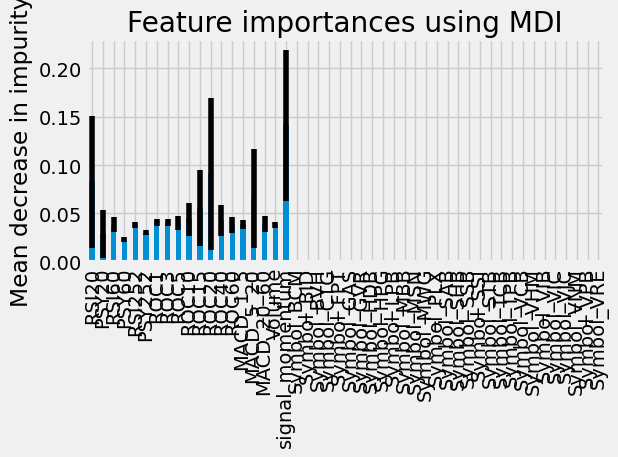

In [42]:
importances = test_model['classifier'].feature_importances_

# feature_names = trainX.drop(columns = ['Symbol']).columns

feature_names = trainX.columns


forest_importances = pd.Series(importances, index=feature_names)

std = np.std([tree.feature_importances_ for tree in test_model['classifier'].estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

In [43]:
# import pickle

# # save the iris classification model as a pickle file
#   model_pkl_file = "random_forest_model_0.5892.pkl"

# with open(model_pkl_file, 'wb') as file:
#     pickle.dump(test_model, file)

# Sharpe Loss

In [74]:
class Lasso_supervised(kt.HyperModel):
    def __init__(self, k,binary):
        self.k = k
        self.binary = binary

    def build(self,hp):
        model = Sequential([
            Dense(1, input_shape = (48,),kernel_regularizer = l1(hp.Choice("l1_weight", [1e-4, 1e-3, 1e-2, 0.1,])),activation= 'sigmoid' if self.binary else None)
        ])
        
        if self.binary == True:
            loss = 'binary_crossentropy'
        else: loss = tf.keras.metrics.RootMeanSquaredError()

        model.compile(
            optimizer=Adam(
                learning_rate=hp.Choice("learning_rate", [1e-3, 1e-1, 1.0]),
                clipnorm = hp.Choice("max_grad_norm", [1e-2, 0.1, 1.0, 10.0])
            ),
            loss= loss,
        )
        return model
    def fit(self, hp, model, *args, **kwargs):
    
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [256,512,1024]),
            **kwargs, epochs = 100, verbose=1
        )


In [75]:
def train_Lasso_supervised(X_train,y_train,k,h,binary = True):

    tuner = kt.GridSearch(
        Lasso_supervised(k = k,binary=binary),
        objective="loss",
        max_trials=100,
        overwrite=True,
        directory="tuning_dir",
        project_name= f"tune_Lasso_supervised_{'binary' if binary else 'reg'}",

    )

    es = EarlyStopping(monitor='loss', verbose=1, patience=25)

    checkpoint_filepath = (
        'Checkpoint/checkpoint_lasso_sup_binary.model.keras' if binary
        else 'Checkpoint/checkpoint_lasso_sup_reg.model.keras'
    )
    model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor = 'loss',
    save_best_only=True)    


    tuner.search(X_train, y_train, callbacks = [es])

    hypermodel = Lasso_supervised(k = k,binary=binary)
    best_hp = tuner.get_best_hyperparameters()[0]
    model = hypermodel.build(best_hp)

    history = hypermodel.fit(best_hp,model,X_train, y_train,callbacks = [model_checkpoint_callback])
    
    return model,history

In [76]:
model, history = train_Lasso_supervised(trainX, trainY,1,1, binary = False)

Trial 100 Complete [00h 00m 36s]
loss: 994072.8125

Best loss So Far: 23092.958984375
Total elapsed time: 00h 40m 44s
Epoch 1/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2507058.5000
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1865483.7500
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1439445.6250
Epoch 4/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1196276.3750
Epoch 5/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1045713.2500
Epoch 6/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 940725.3125
Epoch 7/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 862135.3125
Epoch 8/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 800452.4375
Epoch 9/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 750368.0000
Epoch 10/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 708648.4375
Epoch 11/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 673196.8750
Epoch 12/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 642585.312

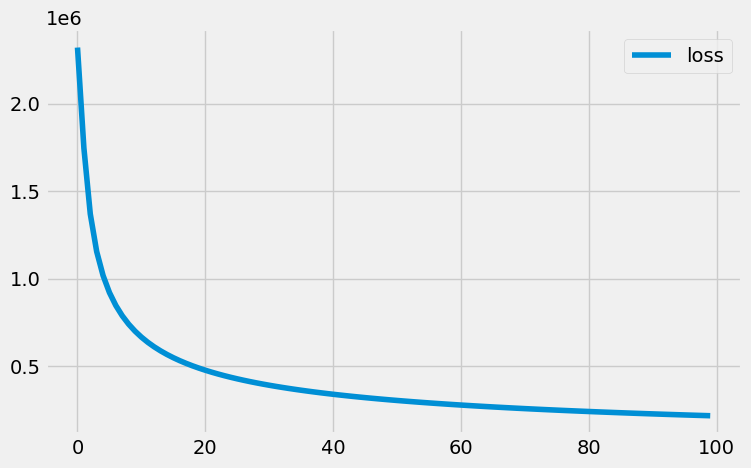

In [77]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

In [78]:
prediction = test_model.predict(testX)
# np.unique(prediction, return_counts= True)
prediction *= (testX["signal_momentum"]>0)
print(classification_report((testX["signal_momentum"]>0) * testY, prediction))

              precision    recall  f1-score   support

         0.0       0.78      0.91      0.84      6753
         1.0       0.47      0.24      0.32      2217

    accuracy                           0.74      8970
   macro avg       0.63      0.58      0.58      8970
weighted avg       0.71      0.74      0.71      8970



In [84]:
np.unique(prediction, return_counts= True)

(array([0., 1.]), array([7833, 1137], dtype=int64))

In [79]:
class MLP_supervised(kt.HyperModel):
    def __init__(self, k,binary):
        self.k = k
        self.binary = binary

    def build(self,hp):
        model = Sequential([
            Dropout(0, input_shape=(48,)),
            Dense(units=hp.Choice(f"units", [5, 20, 40]),activation = hp.Choice('activation', ['relu'])),
            Dropout(rate=hp.Choice("dropout", [0.1, 0.3, 0.5])),
            Dense(1,activation = 'sigmoid' if self.binary else None),
        ])

        if self.binary == True:
            loss = 'binary_crossentropy'
        else: loss = tf.keras.metrics.RootMeanSquaredError()

        model.compile(
            optimizer=Adam(
                learning_rate=hp.Choice("learning_rate", [1e-3, 1e-1, 1.0]),
                clipnorm = hp.Choice("max_grad_norm", [1e-2, 0.1, 1.0, 10.0])
            ),
            loss= loss,
        )
        return model
    def fit(self, hp, model, *args, **kwargs):        

        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [256,512,1024]),
            **kwargs, epochs = 100, verbose=1
        )


In [80]:
def train_MLP_supervised(X_train,y_train,k,h,binary = True):
    
    tuner = kt.GridSearch(
        MLP_supervised(k = k,binary = binary),
        objective="loss",
        max_trials=100,
        overwrite=True,
        directory="tuning_dir",
        project_name= f"tune_MLP_supervised_{'binary' if binary else 'reg'}",
    )

    es = EarlyStopping(monitor='loss', verbose=1, patience=25)

    checkpoint_filepath = (
        'Checkpoint/checkpoint_mlp_sup_binary.model.keras' if binary
        else 'Checkpoint/checkpoint_mlp_sup_reg.model.keras'
    )
    model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor = 'loss',
    save_best_only=True, verbose = 1)    

    tuner.search(X_train, y_train, callbacks = [es])

    hypermodel = MLP_supervised(k = k,binary = binary)
    best_hp = tuner.get_best_hyperparameters()[0]
    model = hypermodel.build(best_hp)

    history = hypermodel.fit(best_hp,model,X_train, y_train,callbacks = [model_checkpoint_callback])
    
    return model,history    

In [81]:
model, history = train_MLP_supervised(trainX, trainY,1,1, binary = True)

Trial 100 Complete [00h 00m 15s]
loss: 0.5583999156951904

Best loss So Far: 0.5567193627357483
Total elapsed time: 00h 26m 23s
Epoch 1/100
128/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 245923.5938
Epoch 1: loss improved from inf to 197176.17188, saving model to Checkpoint/checkpoint_mlp_sup_binary.model.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 241323.4844
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 85268.5781
Epoch 2: loss improved from 197176.17188 to 57785.04297, saving model to Checkpoint/checkpoint_mlp_sup_binary.model.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 85075.0391
Epoch 3/100
134/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1397.3997
Epoch 3: loss improved from 57785.04297 to 348.97498, saving model to Checkpoint/checkpoint_mlp_sup_binary.model.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1338.6243
Epoch 4/100
133/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5632
Epoch 4: loss improved from 348.97498 to 20.06336, sa

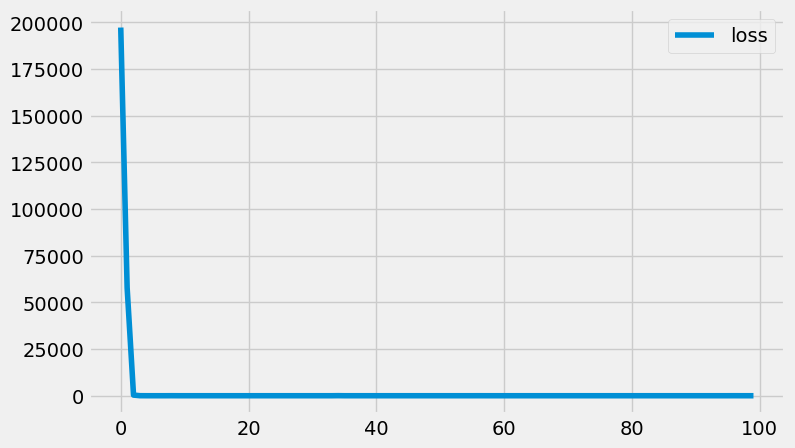

In [82]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

In [83]:
prediction = test_model.predict(testX)
# np.unique(prediction, return_counts= True)
prediction *= (testX["signal_momentum"]>0)
print(classification_report((testX["signal_momentum"]>0) * testY, prediction))

              precision    recall  f1-score   support

         0.0       0.78      0.91      0.84      6753
         1.0       0.47      0.24      0.32      2217

    accuracy                           0.74      8970
   macro avg       0.63      0.58      0.58      8970
weighted avg       0.71      0.74      0.71      8970



In [85]:
np.unique(prediction, return_counts= True)

(array([0., 1.]), array([7833, 1137], dtype=int64))